In [1]:
import numpy as np
from autograd import grad
import matplotlib.pyplot as plt
#import torch
np.set_printoptions(suppress=True)

# Import data
X = np.load('../data/processed/data_tensor.npz')

N = X['N']
M = X['M']
y = X['y']
z = X['z']
n_y = X['n_y']
n_z = X['n_z']
area = X['area']
wind = X['wind']
distance = X['distance']
sI1 = X['sI1']
sI2 = X['sI2'] 
tI1 = X['tI1']
tI2 = X['tI2']
s_i = X['s_i']
s_j = X['s_j']

In [170]:
N

array([[100,  97,  97, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 123, 123, 124]])

In [171]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

## Function

$$
\eta_{i}=\sum_{k=1}^{K} I_{k}^{(t)}(i)\left[\beta_{k}+\delta_{k}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}} \exp{\left(-\eta_{1k} s_{i}\right)}\right)+\gamma_{k} \sum_{j=1}^{M_{i}}\left(\frac{a_{j} z_{j}}{n_{z_{j}}} \exp{\left(-\eta_{2k} s_{j}\right)} w_{i j} \exp{\left(-\alpha_{k} d_{i j}\right)} I_{k}^{(s)}(j)\right)\right]
$$

## Derivatives

$$
\begin{align*}
\frac{\partial \eta_{i}}{\partial \beta_{k}} &= I_{k}^{(t)}(i) \\

\frac{\partial \eta_{i}}{\partial \delta_{k}} &= I_{k}^{(t)}(i)\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}}\right) \exp \left(-\eta_{1 k} s_{i}\right) \\

\frac{\partial \eta_{i}}{\partial \eta_{1 k}} &= -I_{k}^{(t)}(i) \delta_{k} s_{i}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}}\right) \exp \left(-\eta_{1 k} s_{i}\right) \\

\frac{\partial \eta_{i}}{\partial \eta_{2 k}} &= -\gamma_{k} I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z j}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j) s_{j}\right] \\

\frac{\partial \eta_{i}}{\partial \gamma_{k}} &= I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z_{j}}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j)\right] \\

\frac{\partial \eta_{i}}{\partial \alpha_{k}} &= -\gamma_{k} I_{k}^{(t)}(i) \sum_{j=1}^{M_{i}}\left[\left(\frac{a_{j} z_{j}}{n_{z_{j}}}\right) \exp \left(-\eta_{2 k} s_{j}\right) w_{i j} \exp \left(-\alpha_{k} d_{i j}\right) I_{k}^{(s)}(j) d_{i j}\right]
\end{align*}
$$

In [85]:

t = 1
m = 3

# Number of yards i in prior month
N_lag = N[t, m-1]

# Number of yards j in prior month
M_lag = M[t, m-1]

# Number of diseased plants in yard i in prior month
y_lag = y[t, m-1, 0:N_lag]
y_lag = y_lag.reshape(N_lag, 1)

# Number of plants sampled in yard i in prior month
n_y_lag = n_y[t, m-1, 0:N_lag]
n_y_lag = n_y_lag.reshape(N_lag, 1)

# Number of diseased plants in yard i in current month
y_i = y[t, m, 0:N[t, m]]
y_i = y_i.reshape(N[t, m], 1)

# Number of plants sampled in yard i in current month
n_y_i = n_y[t, m, 0:N[t, m]]
n_y_i = n_y_i.reshape(N[t, m], 1)

# Number of diseased plants in yard j in prior month
z_lag = y[t, m-1, 0:M_lag]
z_lag = z_lag.reshape(M_lag, 1)

# Number of plants sampled in yard j in prior month
n_z_lag = n_y[t, m-1, 0:M_lag]
n_z_lag = n_z_lag.reshape(M_lag, 1)

# Total monthly sprays for yard i in prior month
s_i_lag = s_i[t, m-1, 0:N_lag]
s_i_lag = s_i_lag.reshape(N_lag, 1)

# Total monthly sprays for yard j in prior month
s_j_lag = s_j[t, m-1, 0:M_lag]
s_j_lag = s_j_lag.reshape(M_lag, 1)

# Area in hectares of yard j [in prior month]
area_lag = area[t, m-1, 0:M_lag]
area_lag = area_lag.reshape(M_lag, 1)

# Wind run of yard j in prior month
wind_lag = wind[t, m-1, 0:N_lag, 0:M_lag]

# Distance in km between yard i and j [in prior month]
distance_lag = distance[t, m-1, 0:N_lag, 0:M_lag]

# Indicator on whether yard j is affected by an R6-virulent race in prior month
sI1_lag = sI1[t, m-1, 0:M_lag]
sI1_lag = sI1_lag.reshape(M_lag, 1)

# Constant array of 1's for yard j [in prior month]
sI2_lag = sI2[t, m-1, 0:M_lag]
sI2_lag = sI2_lag.reshape(M_lag, 1)

# Indicator on whether yard i is only susceptible to R6-virulent race in current month
tI1_i = tI1[t, m, 0:N[t, m]]
tI1_i = tI1_i.reshape(N[t, m], 1)

# Indicator on whether yard i is susceptible to both races in current month
tI2_i = tI2[t, m, 0:N[t, m]]
tI2_i = tI2_i.reshape(N[t, m], 1)

## Cost Function

$$J(\theta) = 
-\frac{1}{N} \sum_{i=1}^{N} y_{i} \eta_{i}-n_{i} \log \left(1+e^{\eta_{i}}\right)
$$

$$\frac{\partial J}{\partial \theta} =
-\frac{1}{N}\sum_{i=1}^{N} \frac{\partial \eta_{i}}{\partial \theta}\left(y_{i}-\frac{n_{i}}{1+e^{-\eta_{i}}}\right)
$$

In [348]:

t = 1 # 2015
m = 3 # June-July transition

# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta):
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    auto_infection1 = beta1 + delta1 * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    auto_infection2 = beta2 + delta2 * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    dispersal_component1 = gamma1 * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag), axis=0, keepdims=True).T
    dispersal_component2 = gamma2 * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag), axis=0, keepdims=True).T
    
    eta = tI1_i * (auto_infection1 + dispersal_component1) + tI2_i * (auto_infection2 + dispersal_component2)
    
    return eta


def costFunction(theta): 
    
    neg_log_likelihood = -(1/N[t, m]) * np.sum(y_i * eta(theta) - n_y_i * np.log(1 + np.exp(eta(theta))))

    return neg_log_likelihood

# Numerical gradient of the cost function
#gradient = grad(costFunction)

## Optimization

In [349]:
def partial(theta):
    
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    d_beta1 = tI1_i
    d_beta2 = tI2_i
    
    d_delta1 = tI1_i * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_delta2 = tI2_i * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)
    
    d_gamma1 = tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag), axis=0, keepdims=True).T
    d_gamma2 = tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag), axis=0, keepdims=True).T
    
    d_alpha1 = -gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * distance_lag.T), axis=0, keepdims=True).T
    d_alpha2 = -gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * distance_lag.T), axis=0, keepdims=True).T
    
    d_eta11 = -tI1_i * delta1 * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta11 * s_i_lag)
    d_eta12 = -tI2_i * delta2 * s_i_lag * (y_lag / n_y_lag) * np.exp(-eta12 * s_i_lag)

    d_eta21 = -gamma1 * tI1_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta21 * s_j_lag) * (wind_lag * np.exp(-alpha1 * distance_lag)).T * sI1_lag * s_j_lag), axis=0, keepdims=True).T
    d_eta22 = -gamma2 * tI2_i * np.sum(((area_lag * (z_lag / n_z_lag)) * np.exp(-eta22 * s_j_lag) * (wind_lag * np.exp(-alpha2 * distance_lag)).T * sI2_lag * s_j_lag), axis=0, keepdims=True).T

    grad_entries = np.array([d_beta1, d_beta2, d_delta1, d_delta2, d_gamma1, d_gamma2, d_alpha1, d_alpha2, d_eta11, d_eta12, d_eta21, d_eta22])
    
    return grad_entries

# Gradient
def gradient(theta):
    
    mu = y_i - (n_y_i / (1 + np.exp(-eta(theta))))
    
    # Gradient entries
    gradient = - (1 / N[t, m]) * np.sum((partial(theta) * mu), axis=1)
    
    return gradient


# Gradient descent algorithm
def gradientDescent(theta, alpha, num_iters):

    # Make a copy of theta, to avoid changing the original array, since numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # Use a python list to save cost in every iteration
    J_history = []
    
    # Update parameter theta using the gradient
    for i in range(num_iters):
        
        theta = theta - alpha * gradient(theta)
        
        # save the cost J in every iteration
        J_history.append(costFunction(theta))
    
    return theta, J_history

updated final cost:	19.226


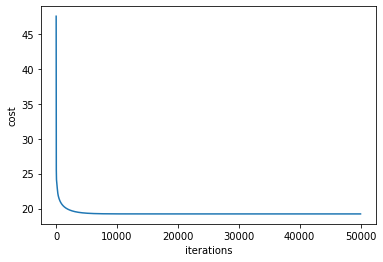

In [359]:
# initialize fitting parameters

# Use below theta for initial training
theta = np.random.randn(12, 1)

# Use below theta to continue from checkpoint
#checkpoint = np.load('../reports/checkpoint.npy', allow_pickle=True)
#theta = checkpoint[0]


# Gradient descent settings
iterations = 50000
alpha = 0.01 # learning rate

theta, J_history = gradientDescent(theta, alpha, iterations)

#print('iteration start:\t{:.3f}'.format(np.int32(checkpoint[1])))
#print('previous final cost:\t{:.3f}'.format(checkpoint[2]))
print('updated final cost:\t{:.3f}'.format(J_history[-1]))
#print('theta:\t[{:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}, {:.3f}]'.format(*theta))

plt.plot(list(range(1, iterations + 1)), J_history)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

In [380]:
theta[2]

array([8.49732157])

In [360]:
# Save trained parameters

#iterations += checkpoint[1]
checkpoint = np.array([theta, iterations, J_history[-1]], dtype=object)
np.save('../reports/checkpoint.npy', checkpoint)

In [366]:
def prob(theta):
    
    p = 1 / (1 + np.exp(-eta(theta)))
    
    return p

In [367]:
print('estimated probability of disease: \n', prob(theta))

estimated probability of disease: 
 [[0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.07501488]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02123466]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.07501488]
 [0.02004516]
 [0.02004516]
 [0.07501488]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.08769218]
 [0.42487619]
 [0.0774977 ]
 [0.03171839]
 [0.02004516]
 [0.02004516]
 [0.02004516]
 [0.13831397]
 [0.02004516]
 [0.09473266]
 [0.02382436]
 [0.41148588]
 [0.0471288 ]
 [0.07371409]
 [0.02754416]
 [0.18360474]
 [0.10608013]
 [0.42331212]
 [0.94101365]
 [0.37332849